## TODO  
モザイク画像のセグメンテーションも一度パッチに分解したものをあとで結合するようにしよう  
多クラス同時セグメンテーションをやったあと，One-hotセグメンテーションはどうなるのかやってみよう

## Image Preparation

Generating patches from mosaics.  
  
imagePatcherSemSeg.py is refered to make preparation program below.  

imagePatcherSemSeg.py is used for deviding a mosaic image and GT segmentation images into the patches like this.  
``` 
$ python imagePatcherSemSeg.py ./datasets/wM1 500 ./results/ wM
```
Here, 500 is the length of a side of a patch.  
  
To gain the number of patches, 
- Rotated patches (90, 180 and 270 degree) are also generated for each patches
- Scale shifted patches (1000, 1000) is generated and resized into same size (500, 500)

In [1]:
import cv2, numpy as np

Parameters

In [2]:
LAYER_NAMES =  ["river",     "decidious", "uncovered", "evergreen", "manmade" ]
LAYER_COLORS = [(64,128,64), (192,0,128), (0,128,192), (128,0,0),   (64,0,128)]
# MOSAIC_NAMES = ["wM1", "wM2", "wM3", "wM4", "wM5", "wM6", "wM7"]
MOSAIC_NAMES = ["wM1"]
PATCH_SIZES = [500, 1000]

RESIZE_TO = 500
EMPTY_THRESHOLD = 50
INDEX_DIGITS = 5
DATASET_DIR = "./datasets/forests/"
OUTPUT_DIR = "./datasets/forests/patches/"

Reading layer images

In [3]:
layers = [[] for i in range(len(MOSAIC_NAMES))]

for mosaic_id, name in enumerate(MOSAIC_NAMES):
    for layer_id in range(len(LAYER_NAMES)):
        layer_file_name = f"{DATASET_DIR}{name}layer{layer_id}.jpg"
        layer = cv2.imread(layer_file_name, cv2.IMREAD_GRAYSCALE)

        if layer is not None:
            print(f"Get layer image: {layer_file_name}")
            layers[mosaic_id].append(layer)

Get layer image: ./datasets/forests/wM1layer0.jpg
Get layer image: ./datasets/forests/wM1layer1.jpg
Get layer image: ./datasets/forests/wM1layer2.jpg
Get layer image: ./datasets/forests/wM1layer3.jpg
Get layer image: ./datasets/forests/wM1layer4.jpg


Generating patches  
Empty patches are skipped

In [4]:
patch_count = 0

In [5]:
def crop_square(image, left, top, size):
    return image[ left : left + size, top : top + size]

def resize(image):
    return cv2.resize(image, (RESIZE_TO, RESIZE_TO))

for m, name in enumerate(MOSAIC_NAMES):

    mosaic = cv2.imread(f"{DATASET_DIR}{name}.jpg")
    size_x, size_y, _ = mosaic.shape
    
    print(f"Create patches for {DATASET_DIR}{name}.jpg")
    
    for patch_size in PATCH_SIZES:

        image_is_empty = lambda image: \
            np.sum(image == 0) <= int(EMPTY_THRESHOLD * (patch_size / RESIZE_TO))

        crop_patch = lambda image, i, j: \
            crop_square(image, i * patch_size, j * patch_size, patch_size)

        step_x, step_y = np.array([size_x, size_y]) // patch_size

        for i in range(step_x):
            for j in range(step_y):

                segm_patch = np.full((patch_size, patch_size, 3), 255, dtype=np.uint8)
                
                # paint the empty patch by layer
                segm_patch_is_empty = True
                for layer_id, layer in enumerate(layers[m]):    
                    layer_patch = crop_patch(layer, i, j)
                    if( image_is_empty(layer_patch) ): continue
                    segm_patch_is_empty = False
                    segm_patch[layer_patch == 0] = LAYER_COLORS[layer_id]

                # start saving the patches if any layers are not empty
                if(segm_patch_is_empty): continue

                index = str(patch_count).zfill(INDEX_DIGITS)
                
                mosaic_patch = crop_patch(mosaic, i, j)

                # resize patches (for scale change)
                segm_patch = resize(segm_patch)
                mosaic_patch = resize(mosaic_patch)

                # rotate patches and save them
                for r in range(4):
                    segm_patch_name = f"{OUTPUT_DIR}{index}_{name}_Segmentation_{i}*{j}_{patch_size}_{r*90}.jpg"
                    cv2.imwrite(segm_patch_name, np.rot90(segm_patch, k=r))

                    mosaic_patch_name = f"{OUTPUT_DIR}{index}_{name}_Mosaic_{i}*{j}_{patch_size}_{r*90}.jpg"
                    cv2.imwrite(mosaic_patch_name, np.rot90(mosaic_patch, k=r))

                patch_count += 1

    print(f"{patch_count * 4} patches are created so far")

Create patches for ./datasets/forests/wM1.jpg
1632 patches are created so far


## Semantic Segmentation by U-net

In [80]:
import sys, os, numpy as np
from optparse import OptionParser

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision.transforms as transforms
from torch.autograd import Function, Variable

from tqdm import tqdm
import random
from PIL import Image # PIL(Python Image Library)
import matplotlib.pyplot as plt
%matplotlib inline

Parameters

In [6]:
DATASET_DIR = './datasets/forests/'
PATCHES_DIR = DATASET_DIR + 'patches/'
CHECKPOINT_DIR =  './results/checkpoint/'

TEST_DATA_RATE = 0.05 # / all
VAL_DATA_RATE = 0.20 # / all - test

BATCH_SIZE = 2
EPOCH = 5
MASK_THRESHOLD = 0.5 # For the highest probability

Reading patches

In [7]:
patch_names = [f[:-4] for f in os.listdir(PATCHES_DIR)] # without extention

random.shuffle(patch_names)


test_data_num = int(len(patch_namesl) * )

# 訓練データとテストデータを分ける
ids = {'train': ids_all[:-n], 'val': ids_all[-n:]}

len_train = len(ids['train'])
len_val = len(ids['val'])

FileNotFoundError: [Errno 2] No such file or directory: './datasets/carvana/train/'

In [5]:
print("全学習データ(画像)数: ", len_train + len_val)
print("訓練データ数: ",  len_train)
print("学習経過評価データ数: ", len_val)

全学習データ(画像)数:  10176
訓練データ数:  9668
学習経過評価データ数:  508


学習に使う画像の読み込み(yield)  
学習させる画像は正方形という制限をかける．  
今回は，左側と右側の2つの画像を1枚の画像から生成する

In [6]:
def to_cropped(ids, dir, suffix):
    for id, pos in ids:
        img = Image.open(dir + id + suffix) # 画像を読み込み
        
        w = img.size[0] # 1918
        h = img.size[1] # 1280
        newW = int(w * SCALE) # 959
        newH = int(h * SCALE) # 640
        
        img = img.resize((newW, newH)) # 画素数を半分に圧縮(SCALE = 0.5) 計算を早めるため？
        img = img.crop((0, 0, newW, newH)) # すでに圧縮された画像の全体を切り取っている．一体なんの意味が？
        img = np.array(img, dtype=np.float32) # numpy array に変換 (w=959, h=640)が(640行, 959列)のnp.arrayになる
        
        # 2つの正方形(640行, 640列)のデータに分割
        # 0は左側，1は右側のデータになる
        h = img.shape[0]
        if pos == 0:
            img = img[:, :h]
        else:
            img = img[:, -h:]
        
        yield img

croppedの実験

(640, 640) (640, 640)


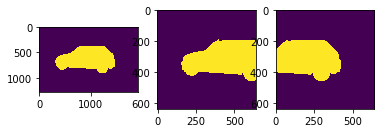

In [7]:
first_img = [i for idx, i in enumerate(ids['train']) if i[0] == 'c9f382c7349e_06']
# to_cropped(first_img, DIR_IMG, '.jpg')
# plt.imshow(to_cropped(first_img, DIR_IMG, '.jpg'))

fig, axs = plt.subplots(1, 3)

img = Image.open(DIR_MASK + first_img[0][0] + '_mask.gif')

axs[0].imshow(img)

newW = int(img.size[0] *SCALE)
newH = int(img.size[1] * SCALE)

img = img.resize((newW, newH))
img = img.crop((0, 0, newW, newH))
img = np.array(img, dtype=np.float32)

h = img.shape[0]
img_0 = img[:, :h]
img_1 = img[:, -h:]
print(img_0.shape, img_1.shape)
img_0 = Image.fromarray(img_0)
img_1 = Image.fromarray(img_1)

axs[1].imshow(img_0)
axs[2].imshow(img_1)
plt.show()

yieldの復習

In [8]:
a = [1,2,3,4,5]

def yld(iterable):
    for i in iterable:
        yield i

# 大きなデータを遅延評価的に出力するために使われるyield
# generatorオブジェクトとして扱われる
# 動作としては，関数内でyieldされたときにそこで止まり，データを返す．
# 得られたgeneratorオブジェクトを回すことで，逐次的にデータを出力できる
for i in yld(a):
    print(i)

# generatorオブジェクトが最後のデータを出力すると，StopIteration例外を吐く
y = yld(a)
for i in range(7):
    print(next(y)) # 逐次的にデータを出力しているとき，内部的にはnextがgeneratorオブジェクトに対して呼ばれている

1
2
3
4
5
1
2
3
4
5


StopIteration: 

画像とマスク画像をセットで読み込む

In [9]:
def get_img_mask(ids):
    
    # generatorを返す (640, 640, 3) のndarrayによる画像データ
    img = to_cropped(ids, DIR_IMG, '.jpg')
    
    # generatorからmapオブジェクトを作成．まだ遅延できる
    # (3, 640, 640)に変形. [色][縦][横]とアクセスできるようにする
    img = map(lambda x: np.transpose(x, axes=[2, 0, 1]), img)
    
    # 0～1の範囲に正規化
    img = map(lambda x: x / 255, img)
    
    # idsが対応するmask画像を取得
    # mask画像は，車の部分が1，そうでないところは0になっているデータなので，そのまま使う
    mask = to_cropped(ids, DIR_MASK, '_mask.gif')
    
    return zip(img, mask)

get_img_maskの実験

In [10]:
first_img = [i for idx, i in enumerate(ids['train']) if i[0] == 'c9f382c7349e_06']
img_mask = list(get_img_mask(first_img))
print(len(img_mask)) # 2つのcropped画像
print(img_mask[0][0].shape) # RGBに最初にアクセスできるようにした元画像データ
print(img_mask[0][1].shape) # 0,1のマスクデータ

2
(3, 640, 640)
(640, 640)


バッチ化関数

In [11]:
def batch(iterable, batch_size):
    b = []
    for i, t in enumerate(iterable):
        b.append(t)
        if (i + 1) % batch_size == 0:
            yield b # batch_sizeの数だけまとめてyield
            b = []
    
    # batch_sizeで割った余りがあるなら出力
    if len(b) > 0:
        yield b

batchの実用例

In [13]:
a = range(10)
list(batch(a, 3))

[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9]]

U-Netの実装

https://cdn.clipkit.co/tenants/86/item_images/images/000/005/056/medium/565a781b-059a-4c99-9ddf-e72b6fc58d4b.png?1541151715

In [20]:
a = np.array([[0, 1], [2, 3]])
b = np.array([[4, 5], [6, 7]])
print(np.concatenate((a, b), axis=0)) # 配列の0階層目に追加していく
print(np.concatenate((a, b), axis=1)) # 配列の1階層目に追加していく

[[0 1]
 [2 3]
 [4 5]
 [6 7]]
[[0 1 4 5]
 [2 3 6 7]]


In [8]:
# Pytorchではbackwardは自動微分によって勾配をforward時に持っておいてくれる
# しかし，nn.Moduleの拡張による独自実装モジュールではforwardを自分で実装する必要がある

# U-netで使う畳み込み層は全て，(conv => BN => ReLU)を2層重ねたもので，2層目は入力と出力のニューロン数が同じ
class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x


# 入力層，ただのdouble_conv
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)
    
    def forward(self, x):
        x = self.conv(x)
        return x


# double_convの前にダウンサンプリングを持つモジュール．
# 図でいう下矢印と右矢印を合わせた部分
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2), # プーリングによるダウンサンプリング, ここでは2*2範囲の中の最大値を出力
            double_conv(in_ch, out_ch)
        )
    
    def forward(self, x):
        x = self.mpconv(x)
        return x


# double_convの前にアップサンプリングを行うモジュール
# 図でいう上矢印と右矢印を合わせた部分

# upsampleを使うものとConvTranspose2dを使うものの違い
# https://discuss.pytorch.org/t/torch-nn-convtranspose2d-vs-torch-nn-upsample/30574
# Transpose is learning parameter while Up-sampling is no-learning parameters. 
# Using Up-samling for faster inference or training because it does not require to update weight or compute gradient

class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()
        
        # アップサンプリングに関する部分
        if bilinear:
            # 今回使うのはこっち
            # Upsampleレイヤは1~3次元のデータのみを受け取る
            # assumed [minibatch x channels x [optional depth] x [optional height] x width]
            # scale_factor: 1つのピクセルを何倍に拡大するか
            # mode: アップサンプリングのアルゴリズム, bilinearは輝度値を直線で結んで観測点の垂線とぶつかる値をとる
                # http://imagingsolution.blog.fc2.com/blog-entry-142.html
            # align_corners: 多分，入出力のサイズにズレがあるときに角を揃えてくれる？
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            # upsampleを使わない場合．こちらはパラメータ学習が行われるらしい
            # 入力チャンネル数，出力チャンネル数，カーネルサイズ,移動幅(stride)
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)
        
        # アップサンプリングが済んだらあとは出力
        self.conv = double_conv(in_ch, out_ch)
    
    # 下からもらう値x1とUの左側からもらう値x2を結合する
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # sizeで得られるのはおそらくバッチ数，チャンネル数，横，縦
        # 縦横のサイズ差を得る
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        
        # 左側からもらう値をパディング． サイズ差の半分ずつを各辺に追加． 値はデフォルトで0
        # 入力， (left, right, top, bottom)
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2), diffY // 2, int(diffY / 2)))
        
        # catenateでチャンネルの階層で結合
        x = torch.cat([x2, x1], dim=1)
        
        # 結合で作られたxを畳み込み層に渡す
        x = self.conv(x)
        return x

# 出力層，マスクになるかどうかの確率ひとつを出力する
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

# UNetの親玉
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256) # Uの左側からやってくるデータとマージを行うので入力2倍
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

Dice係数を算出するクラス  
https://mieruca-ai.com/ai/jaccard_dice_simpson/  
集合同士の類似度の一種  
$$ DSC(A, B) = \frac{2|A \cap B|}{|A| + |B|} $$
片方の要素数がもう片方より多い時には無駄に結果が小さくなってしまうJaccard係数とは違い，2つの集合の平均要素数を計算することで，共通要素数を重視した類似度計算を行う係数
  
Dice係数の微分  
Aについての微分のみを見る  
$ |A \cap B| = inter $, $ |A|+|B|=union $と呼ぶ.(unionじゃないけどねこれ)  
商の微分法から
$$ (DSC(A, B))' = 2 \cdot \frac{inter' \cdot union + inter \cdot union'}{union^2}$$
ここで，  |A|, |B|を全体のうちの割合と考えれば，$|A \cap B| = |A|\cdot|B|$と考えられるので?，
$$ inter' = |B| $$
また，|B|は定数項なので，
$$ union' = 1$$
よって，  
$$ (DSC(A, B))' = 2 \cdot \frac{|B| \cdot union + inter}{union^2}$$

pytorchのview関数の例

In [88]:
# いわゆるreshape. -1によって残りの次元を補完してくれる
# -1だけ設定すると，flatten
print(torch.from_numpy(np.array([1,2,3,4])).view(-1, 2))
print(torch.from_numpy(np.array([1,2,3,4])).view(-1))
print(torch.from_numpy(np.array([[[1,2],[2,3]],[[3,4],[4,5]],[[5,6],[6,7]]])).view(-1))
print()

# unsqueezeはバッチなどのために次元を増やす
print(torch.from_numpy(np.array([1,2,3,4])).unsqueeze(0))
print(torch.from_numpy(np.array([1,2,3,4])).unsqueeze(1))

tensor([[1, 2],
        [3, 4]])
tensor([1, 2, 3, 4])
tensor([1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7])

tensor([1, 2, 3, 4])
tensor([[1],
        [2],
        [3],
        [4]])


In [67]:
# 0, 1のマスクの生成された方とGround TruthのDice係数を求める
class DiceCoeff(Function):
    """Dice coeff for indivisual examples"""
    def forward(self, inpt, target):
        
        # backwardで使うために持っておく
        self.save_for_backward(inpt, target)
        
        # 分母が0にならないよう対策
        eps = 0.0001
        
        # flattenしてベクトルとしてDice係数を計算
        self.inter = torch.dot(inpt.view(-1), target.view(-1))
        
        # Trueのところが1になる．これを合計してunionを求める
        self.union = torch.sum(inpt) + torch.sum(target) + eps
        
        # Dice係数の計算
        t = (2 * self.inter.float() + eps) / self.union.float()
        
        return t
    
    
    # 単一の出力しか持たないため，勾配も一つだけ
    def backward(self, grad_output):
        
        # forward時にsaveしたinptとtarget
        inpt, target = self.saved_variables
        
        # inputとtargetの勾配を求める
        grad_input = grad_target = None
        
        # inptについての勾配を求める(inptについての微分)
        # 上記のDSCの微分演算を適用し，grad_outputをかける
        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target * self.union + self.inter) / self.union * self.union
        
        # targetへの勾配は不要
        if self.needs_input_grad[1]:
            grad_target = None

        return grad_input, grad_target


def dice_coeff(inpt, target):
    """Average Dice coeff for batches"""
    if inpt.is_cuda:
        s = torch.FloatTensor(1).cuda().zero_()
    else:
        s = torch.FloatTensor(1).zero_()
    
    # 全バッチ上の平均Dice係数を求める
    # iをカウンタに利用し，sはcuda計算が可能な1*1配列(スカラ)
    for i, c in enumerate(zip(inpt, target)):
        s = s + DiceCoeff().forward(c[0], c[1])
    
    return s / (i + 1)

ネットワークの学習

In [9]:
# チャンネル数はRGBの3, n_classesは車であるという1つのみ
if torch.cuda.is_available():
    net = UNet(n_channels=3, n_classes=1).cuda()
else:
    net = UNet(n_channels=3, n_classes=1).cpu()

# optimizerにはSGDを利用
# こいつでUNetのパラメータとlossを結びつける
optimizer = optim.SGD(
    net.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=0.0005 # L2penalty rate
)

criterion = nn.BCELoss()

# 1epoch分で行う処理
# 全ての訓練データについて学習を行い，学習誤差を出力
# 全てのテストデータについてDice係数によるテスト誤差を出力
# チェックポイントとしてそこまでの学習モデルを保存

for epoch in range(EPOCH):
    train = get_img_mask(ids['train'])
    val = get_img_mask(ids['val'])
    
    
    
    # train section
    epoch_loss = 0
    for i, b in enumerate(batch(train, BATCH_SIZE)):
        img = np.array([i[0] for i in b]).astype(np.float32) # batch -> channel -> width -> height
        mask = np.array([i[1] for i in b]) # batch -> width -> height
        
        # torchのtensorをimg, maskについて得る
        if torch.cuda.is_available():
            img = torch.from_numpy(img).cuda()
            mask = torch.from_numpy(mask).cuda()
        else:
            img = torch.from_numpy(img).cpu()
            mask = torch.from_numpy(mask).cpu()
        
        # flattenしたmask
        mask_flat = mask.view(-1)
        
        # imgの車の部分(maskされる部分)を推測
        # forwardで計算グラフを構築
        mask_pred = net(img)
        
        # ピクセルごとの出力値にsigmoidをとって確率にする
        mask_prob = F.sigmoid(mask_pred)
        
        # flattenしたマスクされる確率
        mask_prob_flat = mask_prob.view(-1)
        
        # 推測されたデータ vs Ground Truth による訓練誤差の取得
        loss = criterion(mask_prob_flat, mask_flat)
        
        # 勾配の初期化
        optimizer.zero_grad()
        
        # 勾配の計算 ここでcriteirionに渡したpred経由でnetに勾配情報が生成される．
        loss.backward()
        
        # 生成された勾配情報を元に．パラメータを更新
        optimizer.step()
        
        # このエポックでの総訓練誤差を取っておく． あとで平均する
        epoch_loss += loss.item()
        
        # 10画像の訓練ごとに経過出力
        if i % 10 == 0:
            print(f'{i} / {int(len_train/BATCH_SIZE)} ---- loss: {loss.item()}')
    
    # このエポックでの平均訓練誤差を出力
    print(f'Epoch finished ! Loss: {epoch_loss / len_train}')
    
    
    
    # val section
    val_dice = 0
    for j, b in enumerate(val):
        
        # 全てのテスト用画像とテスト用マスクについてテストを行う
        if torch.cuda.is_available():
            img = torch.from_numpy(b[0]).unsqueeze(0).cuda()
            mask = torch.from_numpy(b[1]).unsqueeze(0).cuda()
        else:
            img = torch.from_numpy(b[0]).unsqueeze(0).cpu()
            mask = torch.from_numpy(b[1]).unsqueeze(0).cpu()
        
        # 推論時は勾配を計算する必要がないので，メモリ節約のためにこのようにする
        with torch.no_grad():
            mask_pred = net(img)[0]
            mask_prob = F.sigmoid(mask_pred)
        
        # maskになる確率を超えたところがTrueになるような配列を作り，dice係数を求める
        mask_bin = (mask_prob > THRESHOLD).float()
        val_dice += dice_coeff(mask_bin, mask).item() # FloatTensorが返ってくるのでitemを呼ぶ
        
        # テストの経過表示
        if j % 10 == 0:
            print(f"val: {j}/{len_val}")
    
    # 本エポックのチェックポイントを作成
    torch.save(net.state_dict(), f"{DIR_CHECKPOINT}CP{epoch+1}.pth")
    
    # 本エポック終了
    print(f"Checkpoint {epoch+1} saved !")
    
    # Dice係数の平均を表示
    print(f"Validation Dice Coeff: {val_dice / len_val}")

d:\programming\projects\forests\lib\site-packages\torch\nn\functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 / 4834 ---- loss: 0.6705565452575684


KeyboardInterrupt: 

Load Check Point Data

In [13]:
net = UNet(n_channels=3, n_classes=1).cuda()
net.load_state_dict(torch.load(f"{DIR_CHECKPOINT}CP{EPOCH}.pth"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

本番テストデータによる評価

/root/forests/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/root/forests/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log


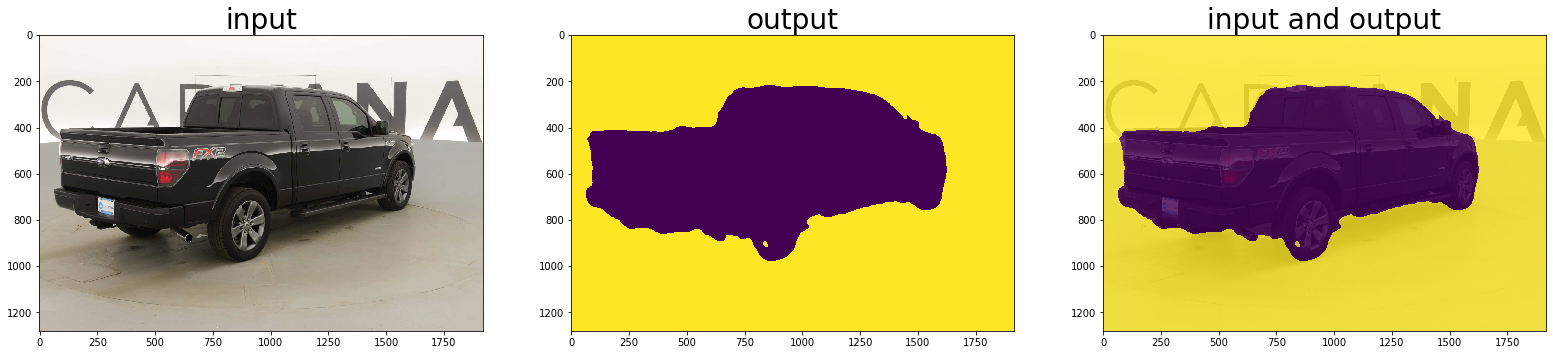

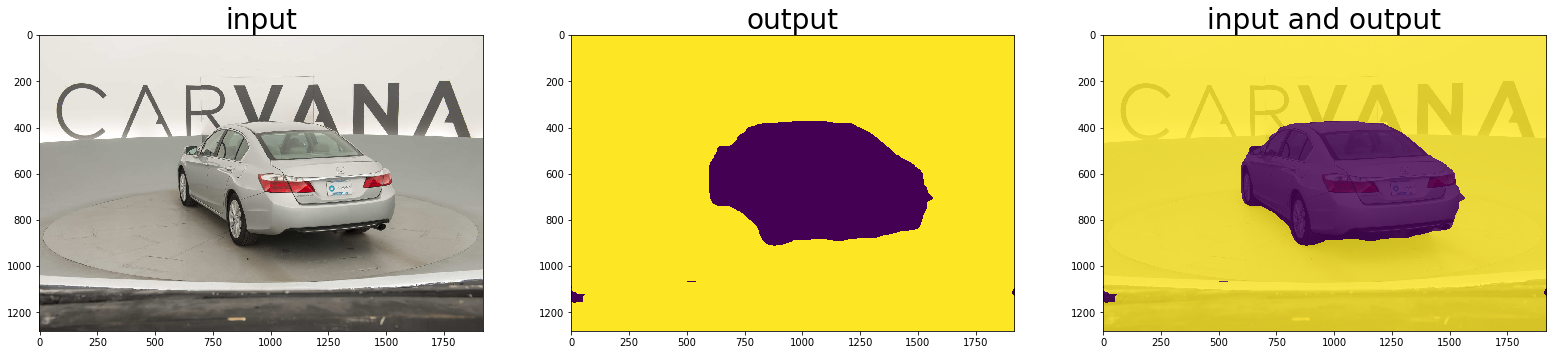

KeyboardInterrupt: 

In [14]:
file_img_test = os.listdir(DIR_IMG_TEST)
random.shuffle(file_img_test)

for i, file in enumerate(file_img_test):
    img_original = Image.open(DIR_IMG_TEST+file)
    img = img_original
    
    # 画質が良すぎるので，学習に使用したデータと同様半分の画質にし，さらに0~1に正規化
    w = img.size[0]
    h = img.size[1]
    
    newW = int(w * SCALE)
    newH = int(h * SCALE)
    
    img = img.resize((newW, newH))
    img = img.crop((0, 0, newW, newH))
    img = np.array(img, dtype=np.float32)
    img = img / 255
    
    # 正方形の画像を入力するため，左右に分ける
    img_left = img[:, :newH]
    img_right = img[:, -newH:]
    
    img_left = np.transpose(img_left, axes=[2, 0, 1])
    img_right = np.transpose(img_right, axes=[2, 0, 1])
    
    # バッチ用の次元を増やしつつ，左右に分けた画像をtorch tensorにする
    if torch.cuda.is_available():
        img_left = torch.from_numpy(img_left).unsqueeze(0).cuda()
        img_right = torch.from_numpy(img_right).unsqueeze(0).cuda()
    else:
        img_left = torch.from_numpy(img_left).unsqueeze(0).cpu()
        img_right = torch.from_numpy(img_right).unsqueeze(0).cpu()
    
    # ここからは推論．勾配計算は不要なため，no_gradを使用
    with torch.no_grad():
        
        # 推論
        mask_left = net(img_left)
        mask_right = net(img_right)

        # maskされる可能性を0~1に正規化しつつ，バッチの次元を削除
        mask_prob_left = F.sigmoid(mask_left).squeeze(0)
        mask_prob_right = F.sigmoid(mask_right).squeeze(0)
        
        # torchvision.transformの画像処理を一気に行う関数を作成し，適用
        tf = transforms.Compose([
                transforms.ToPILImage(), # PIL(Python Image Library)用の画像データに変換
                transforms.Resize(h), # h*hの画像にリサイズし，推論用の圧縮サイズから元の大きさに戻す
                transforms.ToTensor() # torch tensorへ変換
        ])
        mask_prob_left = tf(mask_prob_left.cpu())
        mask_prob_right = tf(mask_prob_right.cpu())
        
        # 次元を落としてnumpy配列化
        mask_prob_left_np = mask_prob_left.squeeze().cpu().numpy()
        mask_prob_right_np = mask_prob_right.squeeze().cpu().numpy()
        
        # 2枚の画像を結合
        mask_prob_np = np.zeros((h, w), np.float32)
        mask_prob_np[:, :w//2+1] = mask_prob_left_np[:, :w//2+1]
        mask_prob_np[:, w//2+1:] = mask_prob_right_np[:, -(w//2-1):]
            
        # サイズを更新(圧縮された画像のサイズだったため)
        h = mask_prob_np.shape[0]
        w = mask_prob_np.shape[1]

        # 次元を一つ増やす． unsqueezeと同様の効果
        mask_prob_np = np.expand_dims(mask_prob_np, 0)
        
        # 増やした次元の0番目にマスクされない確率を, 1番目にマスクされる確率を入れる
        mask_prob_np = np.append(1 - mask_prob_np, mask_prob_np, axis=0)
        
        # mask確率がTHRESHOLD(0.5)を超えているところがTrueになっている配列を得る
        # 今まで確率場について考えてきた努力は!?
        mask = mask_prob_np > THRESHOLD
        
        # Trueのところは255, そうでないところは0にすることでマスク画像の完成
        mask = Image.fromarray((mask[0] * 255).astype(np.uint8))
        
        
        
        # 結果をmatplotlibで出力
        fig = plt.figure(figsize=(27, 7))

        ax1 = fig.add_subplot(131)    
        ax1.imshow(img_original)
        ax1.set_title('input', fontsize=28)

        ax2 = fig.add_subplot(132)
        ax2.imshow(mask)
        ax2.set_title('output', fontsize=28)

        ax3 = fig.add_subplot(133)
        ax3.imshow(img_original)
        ax3.imshow(mask, alpha=0.8) # もう一度imshowすることで追描画できるみたい
        ax3.set_title('input and output', fontsize=28)
        
        plt.show()

imagePatcherSemSeg.pyによるデータだけだと過学習する可能性があるので画像を増やす．  
- 4方向分のデータを作る
- さらに拡大，縮小したデータを作る
    - 一つのパッチを4分割し，同サイズに拡大したデータ
    - 4つのパッチを結合し，同サイズに縮小したデータ

これで3000 * 4 * 4 * (N-1) * (M-1) のデータができる  
このような正方形画像のデータを作成するため，imagePatcherSemSeg.pyを分析し，改造する．  